In [16]:
import pandas as pd
import numpy as np
import random

In [17]:
with open("./data/causal_inference.txt", 'r') as f:
    text = f.readlines()

In [18]:
res = []
for t in text:
    res.append(list(map(int, t.strip('\n').split(" ")[:-1]))) # 最後空文字が入っている。
#     print(t.strip('\n').split(" ")[:-1])

# コロンビア大学で用いられているサンプルデータセット
http://www.cs.columbia.edu/~jebara/6998/hw2.pdf

- the 1st column is the chosen arm
- the 2nd column is binary reward 
- the remaining columns are the context features.

In [19]:
ds = pd.DataFrame(res)
ds.columns = ["arm", "reward"] + [f"feat_{i}" for i in range(100)]

In [20]:
X = ds.loc[:, "feat_0":].values
y = ds.loc[:, "reward"].values
arms = ds.loc[:,"arm"].values

In [21]:
import os, sys

sys.path.append(".")

In [22]:
from src.Arms import ContextualArms

In [23]:
import itertools, os
ds.groupby("arm").mean()["reward"].idxmax()

2

In [24]:
Arms = ContextualArms(n_action=10, max_n_sim=100, X=X, y=y,arms=arms, n_features=X.shape[1])

In [25]:
Arms

In [26]:
d = 100
sigma=1; sigma_0=1
A_inv =sigma_0/sigma * np.eye(d); A_inv
b_t = np.zeros((d, 1))
alpha = 0.05
n_arms = 10
n_sim = 1000
history = dict(chosen_arms=[],rewards=[])
mu_hat = np.zeros((n_arms, 1))

In [40]:
#  Thompson sampling アルゴリズム
for t in range(1, n_sim):
    # 3. draw_theta
    theta = np.random.multivariate_normal(A_inv@b_t.flatten(), sigma**2*A_inv, size=1)
    # 4. A[t]はa_itの転置ver
    # 各アームの特徴量を引く
    # shape : (10, 100) 10 arms, (1, 100)の特徴量ベクトル
    # 1次元目にアーム１から10までの特徴量を順番に格納している。
    A_ = Arms.draw()
    for i in range(n_arms):
        mu_hat[i] = np.dot(A_[i].ravel(), theta.ravel())
    i_star = mu_hat.argmax(0)[0]
    history["chosen_arms"].append(i_star)

    #5. スコア最大の行動 i*　を選択して報酬を観測する。
    reward = Arms.get_reward(index=i_star)
    history["rewards"].append(reward)
    #6.  A-inverse/ bの更新をする。
    a_is = A_[i_star, np.newaxis]
    second_term = (A_inv@a_is.T@a_is@A_inv) / (1+a_is@A_inv@a_is.T)
    A_inv = A_inv - second_term
    b_t += a_is.T*reward    

In [28]:
A_[1, np.newaxis]

array([[70,  0,  0, 18,  0,  0,  0,  0,  0, 33,  0,  0, 23,  0,  0,  0,
         0,  1,  0,  0,  2,  0,  2,  1,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  7,  0,  4, 11,  0,  0,  0,  0,  0,  9,  2, 11,  0,  5,
         0,  0,  3,  0,  0,  0,  0, 31,  0,  0, 14,  6,  1,  0,  0,  1,
         0,  6,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  1,  5,
         6,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,  5,  0,  0,  0,  3,
         5,  0,  0,  0]])

# Logit Regression

- logit モデルは対数事後確率の勾配ベクトルから陽に（解析的に）$\theta$を求めることが難しい。

$- \log\pi (\theta| \{i(s), X(s)\}^t_{s=1})$
$\displaystyle = \frac{\theta^T \theta}{2\sigma^2_0} + \sum^T_{s=1}log(1+\exp(\theta^Ta_{i(s), s})) - \sum^T_{s:X(s)=1}\theta^Ta_{i(s), s} + Constants. $


$G_t(\theta) = - \nabla\log\pi (\theta| \{i(s), X(s)\}^t_{s=1})$
$\displaystyle = \frac{\theta}{2\sigma^2_0} + \sum^t_{s=1}\frac{e^{\theta^Ta_{i(s), s}}a_{i(s), s}}{(1+\exp(\theta^Ta_{i(s), s}))} - \sum^T_{s:X(s)=1}a_{i(s), s}$

- $G_t(\theta) = 0が\theta$について解けない


- そこで、数値計算をする。ニュートン法を用いて、負の対数事後確率を$\hat{\theta}_{MAP}$の周りで２次近似すると、($G_t(\hat{\theta_{MAP}}) = 0$より)

- 負の対数事後確率が多変量正規分布の負の対数ゆうどに近似される。これをLaplas近似というらしい。
    - $\theta_{MAP} \sim N(\hat{\theta_{MAP}}, H_t(\hat{\theta_{MAP}})^{-1})$

In [68]:
# def component_logit_hessian(theta, arm_feature):
#     return np.exp(np.dot(theta.ravel(), arm_feature.ravel()))* arm_feature.T@arm_feature /(1+np.exp(np.dot(theta.ravel(), arm_feature.ravel())))**2
def Hessian_inv(theta, Arms=None):
    assert Arms is not None
#     print(theta.shape)
    n_his = len(Arms.history_idx)
    first_term = np.eye(d)/sigma_0
    # self.cum_matrix
    # initial: self.cum_matrix = np.zeros((d, d))
    exp_theta_arm_feats = np.exp(X[Arms.history_idx]@theta.T)
#     print(exp_theta_arm_feats.shape)
    sum_past_second_term = exp_theta_arm_feats.reshape((n_his, 1,1)) * (X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :])
    second_term = np.sum(sum_past_second_term, axis=0)# (100, 100)
    hessian = first_term + second_term

    return np.linalg.inv(hessian)

def Gradient(theta, sigma_0,  Arms):
    '''gradients vector for logit based posterior probability.'''
    first_term = theta/sigma_0
    exp_theta_arm_feats = np.exp(X[Arms.history_idx]@theta.T)
    second_term = np.sum(exp_theta_arm_feats*X[Arms.history_idx]/(1+exp_theta_arm_feats), axis=0, keepdims=True) #1.
    third_term = np.sum(X[Arms.history_idx][y[Arms.history_idx]==1], axis=0, keepdims=True).astype(np.float64)
    # output shape (100, 1)
    return (first_term + second_term - third_term).T


def newton_iteration(theta, Arms, ith_sim, n_iteration=1000, thr=1e-10):
    is_converged = False
    for _ in range(n_iteration):
        H_inv = Hessian_inv(theta, Arms)
#         print(f"iter_{_}:", theta.shape)
        theta_next = theta - (H_inv@Gradient(theta, sigma_0,  Arms)).ravel()
        if np.sum((theta_next - theta)**2) < thr:
            is_converged = True
            break
        theta = theta_next
    if not is_converged:
        print(f"In {ith_sim} th simulation, theta was not converged.")
#         print(f"iter_{_}:", theta.shape)
    return theta_next, H_inv



In [69]:
d = 100
sigma=1; sigma_0=1
A_inv =sigma_0/sigma * np.eye(d); A_inv
b_t = np.zeros((d, 1))
alpha = 0.05
n_arms = 10
n_sim = 10000
history = dict(chosen_arms=[],rewards=[])
mu_hat = np.zeros((n_arms, 1))

In [70]:
# thetaは今、(1, 100)
theta = np.zeros((1, d))

In [73]:
from tqdm import tqdm 

In [ ]:
# ロジスティックモデル上のトンプソン抽出

#  Thompson sampling アルゴリズム
# offline評価選択できるように修正する必要がある。

for t in tqdm(range(1, n_sim)):

    # WRITE CODE
    # Newton method
    theta, H_inv = newton_iteration(theta, Arms, ith_sim=t, n_iteration=1000, thr=1e-10)
    # 6. draw_theta
    theta_tilde = np.random.multivariate_normal(theta.ravel(), H_inv, size=1)
    # 各アームの特徴量を引く
    # shape : (10, 1, 100) 10 arms, (1, 100)の特徴量ベクトル
    # 1次元目にアーム１から10までの特徴量を順番に格納している。
    A_ = Arms.draw()
    for i in range(n_arms):
        mu_hat[i] = np.dot(A_[i].ravel(), theta_tilde.ravel())
    i_star = mu_hat.argmax(0)[0]
    history["chosen_arms"].append(i_star)
    #5. スコア最大の行動 i*　を選択して報酬を観測する。
    reward = Arms.get_reward(index=i_star)
    history["rewards"].append(reward)



  4%|▍         | 426/9999 [35:34<19:03:01,  7.16s/it]

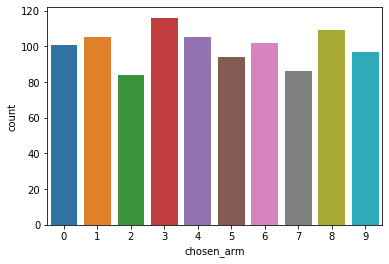

In [56]:
# np.exp(X[Arms.history_idx]@theta.T)
# X[Arms.history_idx]
import seaborn as sns
sns.countplot(x="chosen_arm", data=pd.DataFrame(history["chosen_arms"], columns=["chosen_arm"]))


In [66]:
pd.DataFrame(history).groupby("chosen_arms").agg({"rewards":["mean", "count"]})

rewards      
                 mean count
chosen_arms                
0            0.049505   101
1            0.123810   105
2            0.226190    84
3            0.155172   116
4            0.028571   105
5            0.244681    94
6            0.176471   102
7            0.023256    86
8            0.174312   109
9            0.164948    97

In [65]:
print((ds.groupby("arm").mean()["reward"]))

arm
1     0.020588
2     0.267821
3     0.141684
4     0.051576
5     0.053731
6     0.096573
7     0.194203
8     0.028028
9     0.158907
10    0.030395
Name: reward, dtype: float64


We can implemented one step learning.
Then all i have to do is complete the implementation of it repeatedly.

## If n_sim is sufficiently small, then the draws of theta_tilde wont work because H_inv is not solved.

In [41]:
theta_tilde = np.random.multivariate_normal(theta.ravel(), H_inv, size=1)

LinAlgError: SVD did not converge

In [42]:
H_inv

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

---

In [62]:
# \exp(\theta^T a_{i(s),s})
exp_theta_arm_feats = np.exp(X[Arms.history_idx]@theta.T)
second_term = np.sum(exp_theta_arm_feats*X[Arms.history_idx]/(1+exp_theta_arm_feats), axis=0)

In [83]:
exp_theta_arm_feats

array([[4.22606446e-16],
       [2.26175669e-01],
       [6.66285331e+00],
       [1.34520764e+00],
       [5.72468099e-01],
       [1.31072705e+00],
       [2.54577232e-01],
       [1.29484757e+00],
       [8.84702170e-02],
       [2.28285222e+03]])

In [88]:
X[Arms.history_idx, np.newaxis,:][0]

array([[66,  0,  0, 14,  0,  0,  0,  0,  0, 23,  0,  7, 19,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,
         0,  0,  7,  0,  4,  9,  0,  0,  0,  0,  0, 11,  4,  7,  0, 10,
         0,  0,  0,  0,  0,  0,  0, 38,  0,  1, 12,  8,  0,  0,  0,  0,
         0,  5,  0,  0,  2,  0,  0,  0, 14,  0,  0,  0,  0,  0,  3, 10,
         2,  0,  0,  0,  1,  0,  0,  2,  0,  0,  0,  8,  0,  0,  1,  3,
         6,  0,  0,  0]])

### Hessianの要素を計算する

In [137]:
# np.sum(X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :], axis=0)
hoge = exp_theta_arm_feats.reshape(10, 1,1) * (X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :])
np.sum(hoge, axis=0)

In [138]:
(X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :]).shape

(10, 100, 100)

In [152]:
# 掛け算の動作確認
# 各試行（n_sim）ごとに、(10, 1) × (1, 10)の掛け算がうまくできているか確認
np.all(X[Arms.history_idx[0], np.newaxis].T@X[Arms.history_idx[0], np.newaxis] == (X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :])[0])


True

In [139]:
# 掛け算の動作確認
# 各試行のnp.exp(X[Arms.history_idx]@theta.T)と上の行列がそれぞれ掛け合わせられてるか確認
np.all(hoge[0] == exp_theta_arm_feats[0, 0] * (X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :])[0])

True

In [155]:
np.sum(hoge, axis=0)

(100, 100)

In [140]:
(X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :]).shape

(10, 100, 100)

In [136]:
hoge.shape

(10, 100, 100)

In [110]:
np.all((X[Arms.history_idx, :, np.newaxis]@X[Arms.history_idx, np.newaxis, :])[0] == X[Arms.history_idx[0], :, np.newaxis]@X[Arms.history_idx[0], np.newaxis, :])

True

In [107]:
X[Arms.history_idx[0], :, np.newaxis]@X[Arms.history_idx[0], np.newaxis, :]
# first_term = theta/sigma_0
# exp_theta_arm_feats = np.exp(X[Arms.history_idx]@theta.T)
# second_term = np.sum(exp_theta_arm_feats*X[Arms.history_idx]/(1+exp_theta_arm_feats), axis=0, keepdims=True) #1.
# third_term = np.sum(X[Arms.history_idx][y[Arms.history_idx]==1], axis=0, keepdims=True).astype(np.float64)
# first_term + second_term - third_term

array([[4356,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [48]:
(exp_theta_arm_feats*X[Arms.history_idx])[2] == exp_theta_arm_feats[2] * X[Arms.history_idx][2]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [52]:
np.sum(exp_theta_arm_feats*X[Arms.history_idx], axis=0)

array([7.00050632e+03, 6.55363525e+00, 7.78987402e+04, 1.28421873e+02,
       2.28344424e+04, 0.00000000e+00, 2.49038139e+01, 1.33257066e+01,
       0.00000000e+00, 1.15041526e+04, 3.88149911e+04, 2.22655876e+00,
       5.88031060e+01, 1.40247794e+02, 6.66285331e+00, 3.42495686e+04,
       5.09154464e-01, 1.65345183e+01, 1.18737590e+02, 0.00000000e+00,
       8.46030976e+04, 1.10153461e+01, 0.00000000e+00, 2.05610280e+01,
       0.00000000e+00, 8.84406513e+01, 2.33146851e+03, 1.77921582e+01,
       1.57403770e+01, 3.42470215e+04, 2.28310680e+03, 5.09154464e-01,
       1.27288616e+00, 5.30821302e-01, 7.83649383e+00, 3.19645345e+04,
       2.84978677e+01, 2.29830161e+03, 2.65410651e-01, 2.56022022e+03,
       1.36999059e+04, 0.00000000e+00, 2.51997092e+01, 2.20390979e+01,
       2.15688777e+01, 2.17146132e+02, 5.55484765e+01, 2.14604955e+01,
       4.62589630e+03, 4.57027806e+03, 1.46277277e+01, 2.72598713e+01,
       3.13060856e+00, 2.15160233e+01, 1.99885599e+01, 1.03793556e+02,
      

In [57]:
# exp_theta_arm_feats[2]
(exp_theta_arm_feats*X[Arms.history_idx]/(1+exp_theta_arm_feats))[0] == (exp_theta_arm_feats*X[Arms.history_idx])[0]/(1+exp_theta_arm_feats)[0]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

array([80.07902537,  2.83617888, 76.1638408 , 58.03467343, 13.3484506 ,
        0.        , 10.77747973,  1.73900062,  0.        , 48.95679219,
       22.26810465,  1.49800864, 27.85694738, 60.69422797,  0.86950031,
       20.52711729,  0.40583748,  8.03292197, 17.2349045 ,  0.        ,
       62.39529603,  5.51765069,  0.        ,  2.97255797,  0.        ,
       22.35307394, 22.44831799,  8.26565787,  9.69090105, 18.51368676,
        1.20248088,  0.40583748,  1.0145937 ,  0.48767646,  3.58974398,
       17.23281046, 12.99101484,  8.65064007,  0.24383823, 39.839149  ,
        8.32961103,  0.        ,  4.87145489, 11.19684101,  5.85367997,
       32.85367713, 17.77229189,  9.99881743, 10.00908323,  4.07761416,
        6.10405152,  4.00603761,  1.54030903,  3.82601337,  2.60850092,
       47.35483004,  0.        , 10.86085101, 10.73329428,  9.31451931,
       15.57669426, 10.60062894,  2.11065301,  2.05977525, 44.04225116,
        6.60588943, 14.69022928,  0.36405705,  8.25390759,  8.41

# Calculate Regrets.

In [ ]:
# 関数にするかも
class RegretCalculator():
    '"EnvとAgentのヒストリーを踏まえて、期待リグレットを計算する。"'
    pass

# To be continued in another kernel.